In [66]:
import numpy as np
import pandas as pd

from pathlib import Path

from hbayesdm.models import ra_prospect

import nibabel as nib

from bids import BIDSLayout
from tqdm import tqdm

from sklearn.linear_model import ElasticNet, LinearRegression

from scipy.stats import zscore

import matplotlib.pyplot as plt

import nilearn as nil
from nilearn.image import resample_to_img, load_img, smooth_img
from nilearn.datasets import load_mni152_template, load_mni152_brain_mask
from nilearn.input_data import NiftiMasker
from nilearn.plotting import plot_stat_map, show

from nipy.modalities.fmri import hemodynamic_models
from nipy.modalities.fmri.hemodynamic_models import compute_regressor

import pickle

In [23]:
RAW_DATA_DIR = Path('data/tom_2007/ds000005')
PREP_DIR = Path('output/fmriprep')

In [18]:
layout = BIDSLayout(RAW_DATA_DIR, derivatives=True)
layout.add_derivatives(PREP_DIR)

In [22]:
run_list = layout.get(target='run', return_type='id')
subj_list = layout.get(target='subject', return_type='id')

In [33]:
params = pd.read_csv('models/ra_prospect_params.tsv', sep='\t')
params['subjID'] = params.index + 1

In [60]:
frmi_subject_run = {}
# simple structure for fmri_subject_run
# fmri_subject_run: {
#     subj: {
#         niis: [run1, run2, run3],
#         events: [run1, run2, run3]
#     }
# }

for subject_id in tqdm(layout.get(target='subject', return_type='id')):
    if subject_id not in frmi_subject_run.keys():
        frmi_subject_run[subject_id] = {
            'niis': layout.derivatives['fMRIPrep'].get(subject=subject_id, return_type='file', suffix='bold', extension='nii.gz'),
            'events': layout.get(subject=subject_id, return_type='file', suffix='events', extension='tsv')
        }
    else: # subjID is already exists..
        print(f'error! {subject_id}')
        break

df_all = []

for subject_id in layout.get(target='subject', return_type='id'):
    for i, df_path in enumerate(frmi_subject_run[subject_id]['events']):
        df = pd.read_table(df_path)
        df['subjID'] = int(subject_id)
        df['run'] = i + 1
        df_all.append(df)
    
df_all = pd.concat(df_all)

100%|██████████| 16/16 [00:02<00:00,  5.80it/s]


In [79]:
try: 
    df_X = pd.merge(df_all, params, how='left', on=['subjID'])
except:
    df_all.columns = columns
    df_X = pd.merge(df_all, params, how='left', on=['subjID'])

df_X['utility'] = (df_X['gain'] ** df_X['rho']) - (df_X['lambda'] * (df_X['loss'] ** df_X['rho']))

In [67]:
image_sample = layout.derivatives['fMRIPrep'].get(
        subject=layout.get(target='subject', return_type='id')[0],
        return_type='file',
        suffix='bold',
        extension='nii.gz')[0]

event_sample = layout.get(return_type='file', suffix='events', extension='tsv')[0]

TR = layout.get_tr()

template = load_mni152_template()
mask = load_mni152_brain_mask()

In [69]:
masker = NiftiMasker(mask_img=mask, standardize=True)
fmri_masked = masker.fit_transform(image_sample)
print(fmri_masked.shape)

(240, 228453)


In [87]:
#time_indices = np.linspace(0, int(TR * fmri_masked.shape[0]), int(TR * TR * fmri_masked.shape[0]))

time_indices = np.linspace(0,
                           int(TR * fmri_masked.shape[0]),
                           int(fmri_masked.shape[0]))

In [105]:
def boldify(df_X, subj_i, run_j, column_name, time_indices):
    df_sample = df_X[(df_X['subjID'] == subj_i) & (df_X['run'] == run_j)]
    exp_condition = np.array((df_sample['onset'], df_sample['duration'], df_sample[column_name]))
    signals, _ = compute_regressor(exp_condition, 'canonical', time_indices, con_id='main')
    return signals[:,0]

In [126]:
def get_masked_fmri(layout,subj_i,run_j):
    subj_i = 1
    run_j = 1
    image_sample = layout.derivatives['fMRIPrep'].get(
            subject=f'{subj_i:02d}',
            run= f'{run_j}',
            return_type='file',
            suffix='bold',
            extension='nii.gz')[0]

    masker = NiftiMasker(mask_img=mask, standardize=True)
    fmri_masked = masker.fit_transform(image_sample)
    return fmri_masked 

In [107]:
subj_num = 16
run_num = 3
X = np.array([[boldify(df_X, i, j, 'utility', time_indices) for j in range(1,run_num+1)] for i in range(1,subj_num+1)])
print(X.shape)

In [133]:
Y = np.array([[get_masked_fmri(layout,subj_i,run_j) for j in range(1,run_num+1)] for i in range(1,subj_num+1)])
#print(Y.shape)

In [135]:
Y.dump("temp_Y.dat")

In [136]:
Y.shape

(16, 3)

In [131]:
16 * 16*3

768

In [128]:
subj_i = 1
run_j = 1

In [138]:
x = X[subj_i-1,run_j-1,:]
y = get_masked_fmri(layout,subj_i,run_j)

In [137]:
y.shape

AttributeError: 'NoneType' object has no attribute 'shape'

In [123]:
subj_i = 1
run_j = 1
image_sample = layout.derivatives['fMRIPrep'].get(
        subject=f'{subj_i:02d}',
        run= f'{run_j}',
        return_type='file',
        suffix='bold',
        extension='nii.gz')[0]

masker = NiftiMasker(mask_img=mask, standardize=True)
fmri_masked = masker.fit_transform(image_sample)

In [124]:
fmri_masked.shape

(240, 228453)

In [122]:
def get_masked_fmri(layout,subj_i,run_j)
    subj_i = 1
    run_j = 1
    image_sample = layout.derivatives['fMRIPrep'].get(
            subject=f'{subj_i:02d}',
            run= f'{run_j}',
            return_type='file',
            suffix='bold',
            extension='nii.gz')[0]

    masker = NiftiMasker(mask_img=mask, standardize=True)
    fmri_masked = masker.fit_transform(image_sample)

KeyboardInterrupt: 

In [ ]:
fmri_masked.shape

In [120]:
image_sample = layout.derivatives['fMRIPrep'].get(
        subject=f'{subj_i:02d}',
        run= f'{run_j}',
        return_type='file',
        suffix='bold',
        extension='nii.gz')[0]

In [121]:
image_sample

['/home/cheoljun/project_model_based_fmri/examples/output/fmriprep/sub-01/func/sub-01_task-mixedgamblestask_run-1_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz']

<StemContainer object of 3 artists>

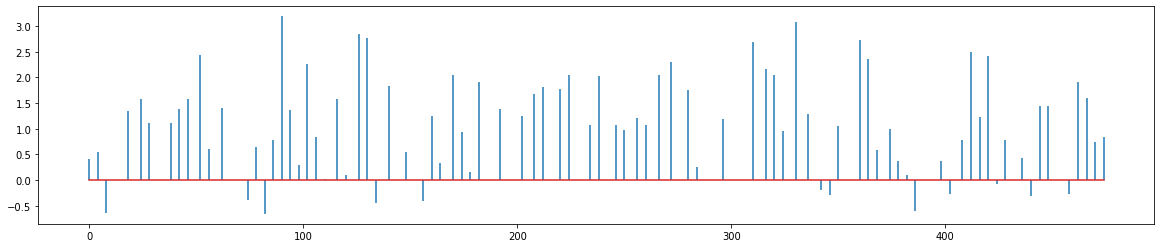

In [82]:
plt.figure(figsize=(20, 4))
plt.stem(df_sample['onset'], df_sample['utility'], markerfmt=' ')

In [88]:
signals, _ = compute_regressor(exp_condition, 'canonical', time_indices, con_id='main')

In [89]:
time_indices.shape

(240,)

In [85]:
signals.shape

(960, 1)

In [101]:
signals = boldify(df_X, 1, 1, 'utility', time_indices)

(240, 1)


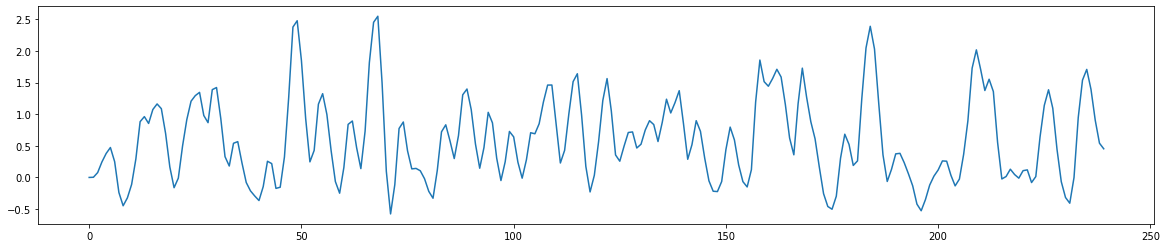

In [90]:
plt.figure(figsize=(20, 4))
print(signals.shape)
plt.plot(signals)

In [73]:
TR * TR * fmri_masked.shape[0]

960.0

In [50]:
subjID = '1'
runID  = '1'
run_event_file = layout.get(subject=subject_id,run=runID, return_type='file', suffix='events', extension='tsv')[0]
x = pd.read_csv(run_event_file, sep='\t')

In [59]:
iparam = params[params['subjID']==int(subjID)]
utilities = (x['gain'] ** iparam['rho']) - (iparam['lambda'] * (x['loss'] ** iparam['rho']))

In [ ]:
masker = NiftiMasker(mask_img=mask, standardize=True)
fmri_masked = masker.fit_transform(image_sample)

In [57]:
iparam = params[params['subjID']==int(subjID)]

In [58]:
ilambda

,rho,lambda,tau,subjID
0,0.452523,1.020844,17.612675,1


In [ ]:
latent_process = {}
latent_process_name = 'utility'
hrf = glover_hrf(config.RESPONSE_TR, oversampling=1)
for name, group in tqdm(df_X.groupby(['subjID', 'run'])):
    subject_id, run = name[0], name[1]
    
    impulse, bold = data2bold(
        group[latent_process_name].to_numpy(),
        group['onset'].to_numpy(),
        config.RESPONSE_TR,
        hrf
    )
    
    name = f'{subject_id:02d}-{run}'
    latent_process[name] = {}
    latent_process[name][f'{latent_process_name}_impulse'] = impulse

In [42]:
frmi_subject_run = {}
# simple structure for fmri_subject_run
# fmri_subject_run: {
#     subj: {
#         niis: [run1, run2, run3],
#         events: [run1, run2, run3]
#     }
# }

for subject_id in tqdm(layout.get(target='subject', return_type='id')):
    if subject_id not in frmi_subject_run.keys():
        frmi_subject_run[subject_id] = {
            'niis': layout.derivatives['fMRIPrep'].get(subject=subject_id, return_type='file', suffix='bold', extension='nii.gz'),
            'events': layout.get(subject=subject_id, return_type='file', suffix='events', extension='tsv')
        }
    else: # subjID is already exists..
        print(f'error! {subject_id}')
        break

100%|██████████| 16/16 [00:02<00:00,  5.56it/s]


In [44]:
subject_id

'16'

In [148]:
zz = nib.load('/usr/local/fsl/data/standard/MNI152lin_T1_2mm.nii.gz').get_fdata()

(91, 109, 91)

In [ ]:
(91, )

In [154]:
126-109

17

In [155]:
126-91

35

10.0

In [183]:
zzz =np.pad(zz,((18,17),(8,9),(0,0)),'constant', constant_values=(10.0))


In [184]:
zzz.shape

(126, 126, 91)

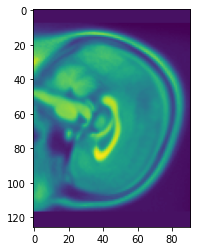

In [185]:
plt.imshow(zzz[63])

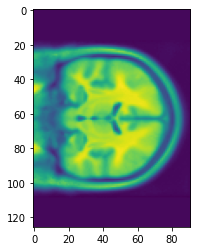

In [186]:
plt.imshow(zzz[:,63,:])

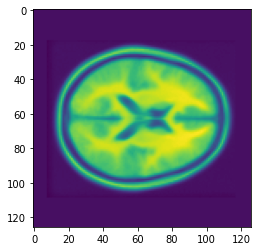

In [187]:
plt.imshow(zzz[:,:,45])

In [188]:
zzz[0,0,0]

10.0

In [189]:
path = '/usr/local/fsl/data/standard/MNI152lin_T1_2mm_brain_padded_126.nii.gz'

In [190]:
nii_zzz = nib.Nifti1Image(zzz, affine=np.eye(4))

In [191]:
nii_zzz.header.get_xyzt_units()
nii_zzz.to_filename('MNI152lin_T1_2mm_brain_padded_126.nii.gz')  #

In [145]:
!ls /usr/local/fsl/data/standard/MNI152lin_T1_2mm_brain.nii.gz

avg152T1_brain.nii.gz
avg152T1.nii.gz
bianca
FMRIB58_FA_1mm.nii.gz
FMRIB58_FA-skeleton_1mm.nii.gz
Fornix_FMRIB_FA1mm.nii.gz
FSL_HCP1065_FA_1mm.nii.gz
FSL_HCP1065_L1_1mm.nii.gz
FSL_HCP1065_L2_1mm.nii.gz
FSL_HCP1065_L3_1mm.nii.gz
FSL_HCP1065_MD_1mm.nii.gz
FSL_HCP1065_MO_1mm.nii.gz
FSL_HCP1065_tensor_1mm.nii.gz
FSL_HCP1065_V1_1mm.nii.gz
FSL_HCP1065_V2_1mm.nii.gz
FSL_HCP1065_V3_1mm.nii.gz
LowerCingulum_1mm.nii.gz
MNI152lin_T1_1mm_brain.nii.gz
MNI152lin_T1_1mm.nii.gz
MNI152lin_T1_1mm_subbr_mask.nii.gz
MNI152lin_T1_2mm_brain_mask.nii.gz
MNI152lin_T1_2mm_brain.nii.gz
MNI152lin_T1_2mm.nii.gz
MNI152_T1_0.5mm.nii.gz
MNI152_T1_1mm_BigFoV_facemask.nii.gz
MNI152_T1_1mm_brain_mask_dil.nii.gz
MNI152_T1_1mm_brain_mask.nii.gz
MNI152_T1_1mm_brain.nii.gz
MNI152_T1_1mm_first_brain_mask.nii.gz
MNI152_T1_1mm_Hipp_mask_dil8.nii.gz
MNI152_T1_1mm.nii.gz
MNI152_T1_2mm_b0.nii.gz
MNI152_T1_2mm_brain_mask_deweight_eyes.nii.gz
MNI152_T1_2mm_brain_mask_dil1.nii.gz
MNI152_T1_2mm_brain_mask_dil.nii.gz
MNI152_T1_2mm_br

In [ ]:
train = {}
unit_time_length = int(config.FMRI_TR / config.RESPONSE_TR)
for subjID in tqdm(subj_list):
    X, y = [] ,[]
    for runID in (run_list):
        _file_name = layout.derivatives['fMRIPrep'].get(subject=subjID,run=runID, return_type='file', suffix='bold', extension='nii.gz')[0]
        _img = nib.load(_file_name).get_fdata()
        time_length = _img.shape[-1]
        _name = f'{subjID}-{runID}'
        _x = latent_process[_name][f'{latent_process_name}_bold']
        _x_desired_length = len(_x)//unit_time_length
        _x = _x[:_x_desired_length*unit_time_length]
        final_length = min(time_length,_x_desired_length)
        _x = _x.reshape(-1,unit_time_length).mean(-1)[:final_length] 
        _img = _img[...,:final_length]
        X.append(np.array(_x))
        y.append(_img)
    train[subjID] = {'X':np.concatenate(X,-1),
                     'y':np.concatenate(y,-1)}